# Импорты

Импорт всех необходимых библиотек

In [1]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [5]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [6]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [7]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

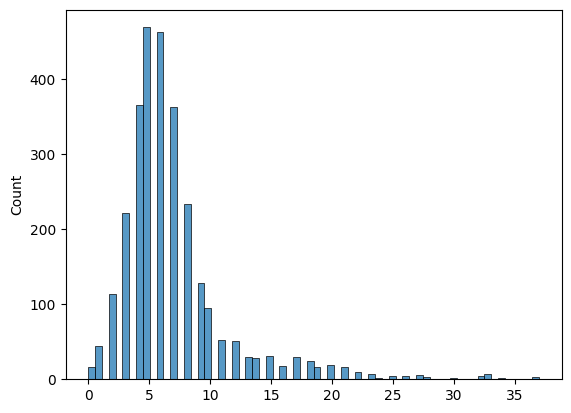

In [8]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [9]:
df = df.drop(df[df['bmi']>80].index)

In [10]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

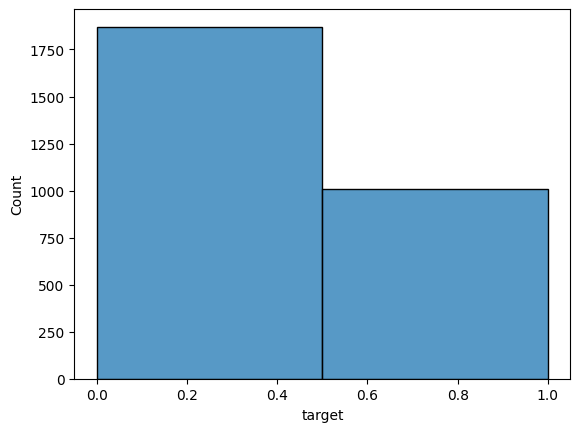

In [11]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [12]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

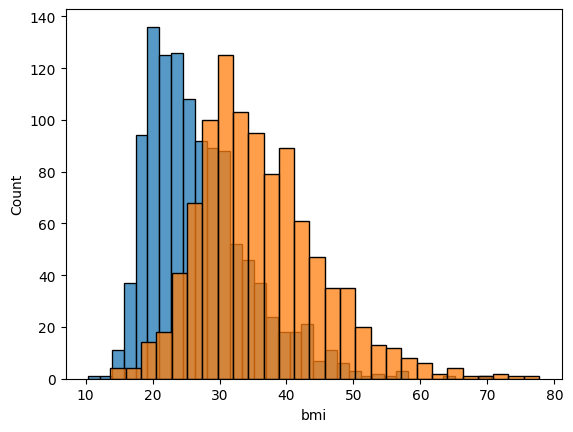

In [13]:
sns.histplot(df[df['target']==0]['bmi'], legend=True)
sns.histplot(df[df['target']==1]['bmi'], legend=True)

In [14]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_test

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
2268,NaN,NaN,NaN,558.58,26.42,2340.74,103.35,1940.94,1183.86,20.68,16.70,70.77,3.36,2.69,15.60,18.35,2729.87,28.54,1.51,85.22,901.28,5.43,0.1,52.19,2.39,235.49,15.46,294.74,12.66,717.51,1.51,1.87,4.57,1.56,295.96,2.33,247.89,148.80,NaN,3.99,1234.88,1.55,0.00,1.25,16.05,10.51,0.01,2.05,62.53,2.14,1.70,0.63,10.91,64.10,2.29,1.74,120.0,4.04,19.36,201.14,93.73,7.54,14.21,1.12,9.46,25.16,114.51,78.43,7.59,8.12,1,0,0,1,28.378215,0
263,NaN,NaN,NaN,566.87,37.27,3510.99,3.18,1585.01,1053.22,1.39,24.47,86.70,4.34,4.03,13.04,7.26,1487.29,15.00,2.38,93.16,548.41,35.81,NaN,0.45,3.33,36.67,21.70,167.23,NaN,677.64,0.74,1.33,2.47,0.96,71.05,5.00,158.67,133.34,0.12,5.76,1131.12,1.29,NaN,2.15,9.29,6.24,NaN,3.08,2.17,3.42,1.25,0.86,2.56,46.67,3.03,NaN,NaN,5.70,16.73,75.67,80.60,NaN,0.79,0.43,NaN,NaN,70.76,183.65,NaN,7.16,0,1,1,0,30.422968,0
2781,NaN,55.30,NaN,373.79,22.48,2831.04,68.13,1683.66,898.53,12.91,17.14,57.14,2.55,2.41,11.99,17.01,1563.71,37.76,1.35,76.42,363.36,3.47,2.4,18.11,1.97,197.40,15.01,192.76,4.25,675.48,1.25,1.20,2.64,0.88,254.24,2.21,165.44,236.00,0.01,3.45,805.90,0.91,0.04,1.17,11.79,6.66,0.00,1.87,40.85,1.99,1.23,0.54,10.34,44.10,1.96,0.61,8.0,3.48,16.72,117.18,39.25,3.62,8.78,0.66,3.35,8.69,79.97,110.25,3.33,5.64,1,0,0,1,34.089796,0
848,NaN,NaN,NaN,224.69,16.46,1294.51,82.57,1150.26,1127.12,19.07,7.95,50.09,2.07,1.59,12.61,5.50,2686.51,20.77,0.90,42.56,585.02,NaN,NaN,37.02,1.43,152.17,7.19,236.79,14.94,468.62,0.91,1.06,3.25,1.31,219.54,1.51,100.82,172.13,NaN,2.34,777.48,0.56,0.00,0.74,13.24,4.18,0.01,1.14,210.44,1.29,0.40,0.37,6.60,19.30,1.33,3.59,NaN,2.28,10.64,154.90,58.28,16.54,4.17,0.95,27.60,61.00,50.37,93.27,20.40,5.23,1,0,1,0,26.284467,0
2796,19.04,40.16,27.33,1515.96,61.02,5880.47,215.07,6200.30,2685.37,85.62,121.25,247.34,15.68,9.36,41.92,72.57,7742.37,141.25,5.51,296.43,2134.57,NaN,1.2,24.95,8.22,654.78,117.61,1486.91,14.41,4149.66,3.90,6.82,11.87,3.78,994.91,16.69,700.01,849.61,0.12,14.79,4054.98,3.80,0.05,3.59,55.68,89.80,0.17,6.39,180.66,7.69,2.26,2.24,102.73,187.22,9.32,1.90,40.0,14.93,62.65,528.40,101.08,5.80,55.06,5.31,10.72,24.47,292.86,61.39,7.68,32.64,1,0,0,1,25.394565,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,NaN,53.90,32.40,879.03,47.87,3209.27,94.11,2605.19,1615.79,16.49,26.01,120.86,7.10,5.57,18.41,26.47,3373.42,47.08,3.03,127.32,974.40,0.47,0.4,14.73,5.00,220.81,22.27,320.30,10.18,1014.22,1.26,2.14,6.13,1.95,284.00,4.83,190.88,472.00,NaN,8.09,1628.16,1.81,0.19,2.84,20.01,14.78,0.03,4.24,104.28,4.60,1.19,1.19,11.74,NaN,4.37,1.24,NaN,8.10,23.74,6.84,88.14,5.38,3.02,1.31,12.93,32.63,182.07,72.98,9.17,14.40,0,1,1,0,27.896303,1
2746,21.30,44.80,30.50,823.18,59.55,6033.45,215.31,3554.09,3268.89,30.96,26.32,137.61,4.22,4.06,32.84,17.46,4820.66,54.69,2.00,136.19,2194.44,0.20,NaN,21.86,3.48,462.86,23.68,578.10,5.74,2197.92,2.67,3.57,7.40,2.71,585.30,7.95,297.75,423.20,0.08,5.86,2482.85,2.82,9.34,1.75,33.09

In [15]:
df_train = df.drop(df_test.index)
df_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,18.0,43.3,22.8,148.86,13.66,1495.20,46.12,981.38,792.79,10.46,8.36,30.54,1.16,0.95,8.25,10.06,1370.94,22.00,0.55,45.36,314.95,1.57,1.20,20.88,0.82,119.19,7.66,167.39,4.63,624.41,0.67,0.72,1.72,0.66,134.80,1.20,63.84,124.40,0.02,1.42,519.06,0.77,0.01,0.41,7.36,6.29,0.01,0.72,40.34,0.82,0.32,0.23,6.67,19.18,0.85,0.82,48.00,1.45,10.10,87.20,21.02,4.78,6.31,0.52,3.88,9.44,39.28,45.79,4.36,2.92,1,0,0,1,23.335466,0
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13

In [16]:
x_train = df_train.drop(columns=['target'])
y_train = df_train['target']

In [17]:
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [18]:
column_names = x_train.columns

In [19]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

In [20]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [21]:
x_train = x_train.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,NaN,-1.276486,-1.164212,-0.857279,-1.312533,-1.054624,-1.022811,-1.103052,-1.376905,NaN,NaN,-1.372296,-0.941938,-1.157503,NaN,NaN,-1.309217,-1.065182,-0.268352,NaN,NaN,NaN,-1.107208,-1.078364,-1.179625,NaN,-0.776141,-1.064593,-1.386977,-1.240511,-1.346616,-1.153168,NaN,NaN,NaN,NaN,NaN,-1.413887,-1.099295,NaN,NaN,-1.240375,-0.935237,NaN,NaN,-0.421444,NaN,NaN,NaN,-0.865352,NaN,NaN,NaN,NaN,NaN,-1.365685,NaN,NaN,NaN,-0.875137,-1.056702,NaN,NaN,-1.409718,NaN,NaN,-1.243336,-0.911642,-0.273921,-0.462681,-0.674440,NaN
1,NaN,NaN,NaN,NaN,-1.277234,-1.164344,-0.951426,-1.344711,-0.801788,-1.038260,-1.104141,-1.381017,NaN,NaN,-1.380755,-0.943496,-1.177215,NaN,NaN,-1.310972,-1.070111,-0.322807,NaN,NaN,NaN,-1.161657,-1.079546,-1.191867,NaN,-0.778992,-1.078907,-1.379380,-1.235285,-1.361332,-1.168774,NaN,NaN,NaN,NaN,NaN,-1.421806,-1.105808,NaN,NaN,-1.256784,-0.936966,NaN,NaN,-0.502652,NaN,NaN,NaN,-0.867198,NaN,NaN,NaN,NaN,NaN,-1.357301,NaN,NaN,NaN,-0.779360,-1.056702,NaN,NaN,-1.409283,NaN,NaN,-1.245759,-0.911642,-0.273921,-0.462681,-0.674440,NaN
2,NaN,NaN,NaN,NaN,-1.276486,-1.158009,-0.872166,-1.300416,-1.187605,-1.013543,-1.103052,-1.374165,NaN,NaN,-1.353070,-0.941938,-1.166253,NaN,NaN,-1.308947,-1.057769,-0.163598,NaN,NaN,NaN,-1.105741,-1.078364,-1.169783,NaN,-0.775402,-1.057436,-1.402172,-1.243123,-1.339259,-1.201591,NaN,NaN,NaN,NaN,NaN,-1.412597,-1.099295,NaN,NaN,-1.239692,-0.935237,NaN,NaN,-0.408370,NaN,NaN,NaN,-0.865352,NaN,NaN,NaN,NaN,NaN,-1.344026,NaN,NaN,NaN,-0.989652,-1.064679,NaN,NaN,-1.408124,NaN,NaN,-1.232431,1.096922,-0.273921,-0.462681,-0.674440,NaN
3,NaN,NaN,NaN,-1.168136,-1.275738,-1.167021,NaN,-1.392995,-1.594613,NaN,-1.103596,-1.388934,-1.321635,-1.358906,-1.428436,-0.945573,-1.295931,NaN,-1.299947,-1.310567,-1.089654,NaN,NaN,NaN,-1.353687,NaN,-1.079546,-1.270978,NaN,-0.783251,-1.107535,-1.424964,-1.248348,-1.376047,-1.365503,-0.949624,-1.186114,NaN,NaN,-1.340502,-1.447235,-1.112321,NaN,-1.307038,-1.288234,-0.939560,NaN,-1.344527,NaN,-1.343762,-0.392326,-1.358777,-0.870275,NaN,-1.377358,NaN,NaN,-1.357590,-1.389439,NaN,-0.853842,NaN,-1.012555,-1.144450,NaN,NaN,-1.410297,NaN,NaN,-1.260298,-0.911642,-0.273921,-0.462681,-0.674440,NaN
4,NaN,NaN,NaN,-1.166794,-1.276112,-1.168329,NaN,-1.392567,-1.593937,NaN,-1.102508,-1.386041,-1.315072,-1.354659,-1.428436,-0.946092,-1.294635,NaN,-1.292760,-1.312187,-1.089555,NaN,NaN,NaN,-1.348884,NaN,-1.077774,-1.270258,NaN,-0.783189,-1.107535,-1.424964,-1.248348,-1.376047,-1.365157,-0.945359,-1.183542,NaN,NaN,-1.332111,-1.445304,-1.112321,NaN,-1.298407,-1.286183,-0.940424,NaN,-1.338810,NaN,-1.338641,NaN,-1.340284,-0.870275,NaN,-1.372175,NaN,NaN,-1.351805,-1.387343,NaN,-0.853749,-0.793150,-1.012555,-1.144450,NaN,NaN,-1.408993,NaN,NaN,-1.254240,-0.911642,-0.273921,-0.462681,-0.674440,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,-0.438630,-0.931341,-1.107627,-0.806192,-0.767133,-0.533646,-0.598

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



## Отбор признаков get_feature_importance из CatBoost

In [22]:
model = CatBoostClassifier(random_seed=42)
model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)
model.get_feature_importance(catboost.Pool(x_train))

Learning rate set to 0.03954
0:	learn: 0.6655175	test: 0.6886747	best: 0.6886747 (0)	total: 59.1ms	remaining: 59s
200:	learn: 0.2418163	test: 0.6503331	best: 0.6499600 (153)	total: 970ms	remaining: 3.86s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6486143921
bestIteration = 219

Shrink model to first 220 iterations.


array([ 0.91089126,  3.81576735,  1.529084  ,  1.36642006,  0.45893879,
        1.02344508,  1.00671687,  0.68314386,  1.01574365,  0.59694157,
        0.85747053,  0.36479795,  0.29984386,  0.59763972,  0.65845061,
        1.5927993 ,  0.24154906,  0.86460504,  0.51979663,  0.98703646,
        0.99947167,  1.61626438,  1.06321839,  0.94076839,  0.53583319,
        0.87325446,  0.37887012,  0.57811045,  1.02592341,  0.44591866,
        0.73364576,  0.7617477 ,  0.89897605,  0.98174469,  1.14578586,
        1.23854146,  1.26791164,  2.69996509,  1.42178378,  0.55400004,
        0.48184099,  1.2870077 ,  2.31397877,  1.02720018,  0.90750707,
        1.68128975,  2.72244833,  0.35167515,  1.1705885 ,  0.52911977,
        1.13094047,  0.44583468,  0.80643346,  0.32527421,  0.27287644,
        0.9751879 ,  0.87531544,  0.94066524,  0.1964254 ,  1.80540642,
        1.6569807 ,  1.0523256 ,  1.99372979,  0.37974543,  1.30360065,
        0.69232178,  1.14253098,  1.01670666,  0.56626535,  0.41

<BarContainer object of 75 artists>

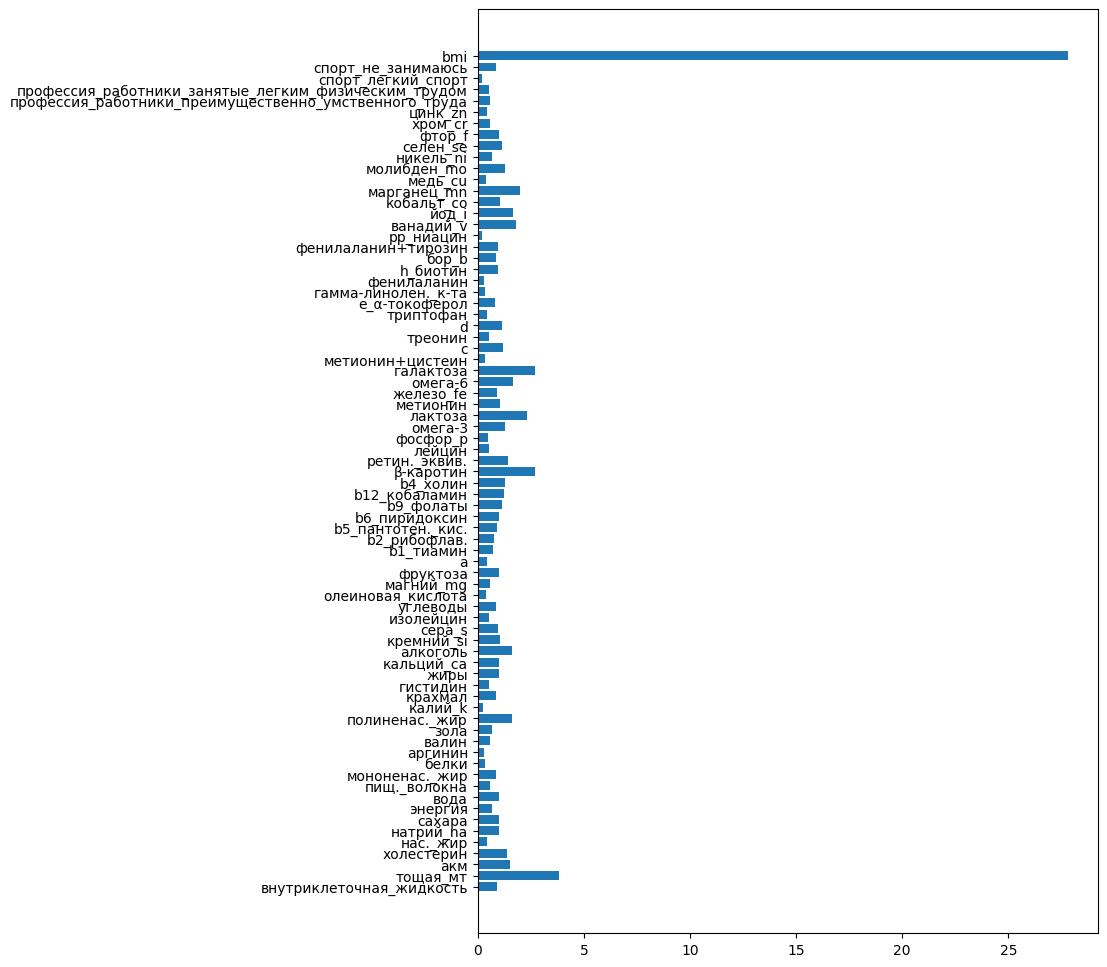

In [23]:
plt.figure(figsize=(8,12))
plt.barh(column_names, model.get_feature_importance(catboost.Pool(x_train)))

In [24]:
import heapq
importances = model.get_feature_importance(catboost.Pool(x_train))
max_imp = heapq.nlargest(9, importances)

features_selected_indx = np.where(np.isin(importances, max_imp))[0]
features_selected_indx

array([ 1, 37, 42, 45, 46, 59, 60, 62, 74])

In [25]:
features_selected = df.columns[features_selected_indx]
features_selected

Index(['тощая_мт', 'β-каротин', 'лактоза', 'омега-6', 'галактоза', 'ванадий_v',
       'йод_i', 'марганец_mn', 'bmi'],
      dtype='object')

Убираем из признаков ИМТ

In [26]:
#features_selected = features_selected[:-1]
features_selected

Index(['тощая_мт', 'β-каротин', 'лактоза', 'омега-6', 'галактоза', 'ванадий_v',
       'йод_i', 'марганец_mn', 'bmi'],
      dtype='object')

## Финальный набор признаков

In [27]:
x_train_selected = x_train.iloc[:,features_selected_indx]
x_test_selected = x_test.iloc[:,features_selected_indx]

<Axes: ylabel='Count'>

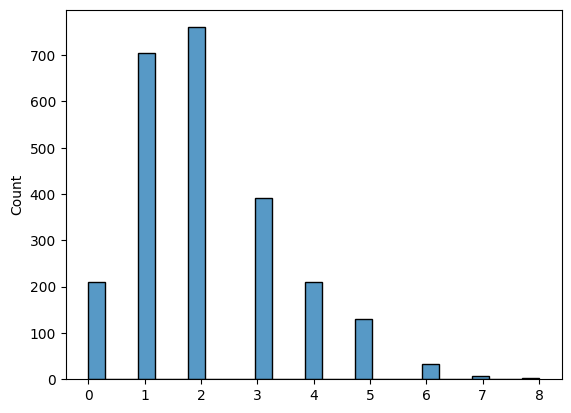

In [28]:
missing_features_selected = x_train_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

<Axes: ylabel='Count'>

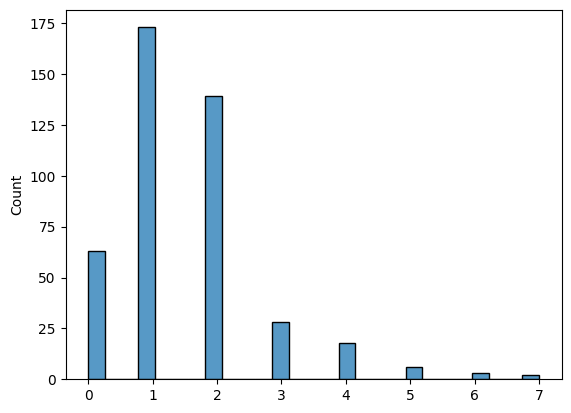

In [29]:
missing_features_selected = x_test_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

Видно, что в тренировочной и тестовой выборках с отобранными 9 параметрами, подавляющее большинство строк имеют 6 значимых признаков и более. Соответственно, на отобранных данных можн проводить обучение.

# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [30]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean') #IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_test_imp = it_imp.transform(x_test)

In [31]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [32]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-11 10:35:39,352] A new study created in memory with name: no-name-a3475a29-8d11-4cdd-8c20-b8c11b5ca662
[I 2024-11-11 10:35:43,242] Trial 0 finished with value: 0.35738831615120276 and parameters: {'max_depth': 5, 'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.35738831615120276.
[I 2024-11-11 10:35:47,913] Trial 1 finished with value: 0.38926174496644295 and parameters: {'max_depth': 5, 'n_estimators': 600, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.38926174496644295.
[I 2024-11-11 10:35:53,786] Trial 2 finished with value: 0.46687697160883285 and parameters: {'max_depth': 10, 'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.46687697160883285.
[I 2024-11-11 10:35:55,361] Trial 3 finished with value: 0.2631578947368421 and parameters: {'max_depth': 3, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 2 with v

In [33]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 3}
Best ROC-AUC score: 0.46687697160883285


In [34]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=500)

Метрики, получаемые из кросс-валидации

In [35]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([4.58578587, 4.6753149 , 4.66713357, 4.68053198, 4.51179481]),
 'score_time': array([0.09674096, 0.08892274, 0.09104228, 0.09072924, 0.08957267]),
 'test_accuracy': array([0.74285714, 0.81428571, 0.8122449 , 0.80408163, 0.76734694]),
 'test_precision_macro': array([0.83610763, 0.80382883, 0.79649031, 0.77628938, 0.74522893]),
 'test_recall_macro': array([0.60704175, 0.75632256, 0.75971423, 0.77981721, 0.77223584]),
 'test_f1_macro': array([0.59821429, 0.77201029, 0.77287842, 0.77798335, 0.75087413]),
 'test_roc_auc': array([0.91377377, 0.89695795, 0.8694826 , 0.84784054, 0.8470235 ])}

In [36]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [37]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [38]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [39]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.86      0.68       216
           1       0.69      0.32      0.44       216

    accuracy                           0.59       432
   macro avg       0.63      0.59      0.56       432
weighted avg       0.63      0.59      0.56       432

F2-score:  0.36269430051813467


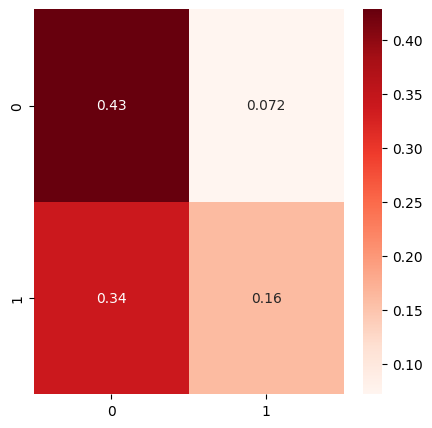

In [40]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [41]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [42]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-11 10:38:49,259] A new study created in memory with name: no-name-0000c7e4-674f-4c3e-becc-ab20ac789f55


[10:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:38:50,348] Trial 0 finished with value: 0.592255125284738 and parameters: {'max_depth': 7, 'n_estimators': 400}. Best is trial 0 with value: 0.592255125284738.


[10:38:50] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:38:51,936] Trial 1 finished with value: 0.607538802660754 and parameters: {'max_depth': 6, 'n_estimators': 800}. Best is trial 1 with value: 0.607538802660754.


[10:38:51] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:38:55,320] Trial 2 finished with value: 0.5912240184757505 and parameters: {'max_depth': 9, 'n_estimators': 1000}. Best is trial 1 with value: 0.607538802660754.


[10:38:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:38:55,593] Trial 3 finished with value: 0.6050420168067226 and parameters: {'max_depth': 3, 'n_estimators': 300}. Best is trial 1 with value: 0.607538802660754.


[10:38:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:38:55,863] Trial 4 finished with value: 0.6050420168067226 and parameters: {'max_depth': 3, 'n_estimators': 300}. Best is trial 1 with value: 0.607538802660754.
[I 2024-11-11 10:38:56,050] Trial 5 finished with value: 0.5949367088607594 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 1 with value: 0.607538802660754.


[10:38:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:38:56] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:38:57,239] Trial 6 finished with value: 0.6170212765957448 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 6 with value: 0.6170212765957448.


[10:38:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:38:57,747] Trial 7 finished with value: 0.5890410958904109 and parameters: {'max_depth': 7, 'n_estimators': 200}. Best is trial 6 with value: 0.6170212765957448.


[10:38:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:38:58,346] Trial 8 finished with value: 0.5890410958904109 and parameters: {'max_depth': 8, 'n_estimators': 200}. Best is trial 6 with value: 0.6170212765957448.


[10:38:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:00,049] Trial 9 finished with value: 0.5898617511520737 and parameters: {'max_depth': 9, 'n_estimators': 500}. Best is trial 6 with value: 0.6170212765957448.


[10:39:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:01,163] Trial 10 finished with value: 0.6026200873362445 and parameters: {'max_depth': 5, 'n_estimators': 700}. Best is trial 6 with value: 0.6170212765957448.


[10:39:01] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:02,744] Trial 11 finished with value: 0.6043478260869565 and parameters: {'max_depth': 5, 'n_estimators': 1000}. Best is trial 6 with value: 0.6170212765957448.


[10:39:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:04,025] Trial 12 finished with value: 0.6026200873362445 and parameters: {'max_depth': 5, 'n_estimators': 800}. Best is trial 6 with value: 0.6170212765957448.


[10:39:04] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:05,627] Trial 13 finished with value: 0.607538802660754 and parameters: {'max_depth': 6, 'n_estimators': 800}. Best is trial 6 with value: 0.6170212765957448.


[10:39:05] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:06,730] Trial 14 finished with value: 0.6199575371549894 and parameters: {'max_depth': 4, 'n_estimators': 900}. Best is trial 14 with value: 0.6199575371549894.


[10:39:06] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:07,940] Trial 15 finished with value: 0.6170212765957448 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 14 with value: 0.6199575371549894.


[10:39:07] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:08,684] Trial 16 finished with value: 0.6170212765957448 and parameters: {'max_depth': 4, 'n_estimators': 600}. Best is trial 14 with value: 0.6199575371549894.


[10:39:08] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:09,771] Trial 17 finished with value: 0.6199575371549894 and parameters: {'max_depth': 4, 'n_estimators': 900}. Best is trial 14 with value: 0.6199575371549894.


[10:39:09] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:13,231] Trial 18 finished with value: 0.593103448275862 and parameters: {'max_depth': 10, 'n_estimators': 900}. Best is trial 14 with value: 0.6199575371549894.


[10:39:13] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:13,967] Trial 19 finished with value: 0.6170212765957448 and parameters: {'max_depth': 4, 'n_estimators': 600}. Best is trial 14 with value: 0.6199575371549894.


[10:39:13] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:15,075] Trial 20 finished with value: 0.6026200873362445 and parameters: {'max_depth': 5, 'n_estimators': 700}. Best is trial 14 with value: 0.6199575371549894.


[10:39:15] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:16,175] Trial 21 finished with value: 0.6199575371549894 and parameters: {'max_depth': 4, 'n_estimators': 900}. Best is trial 14 with value: 0.6199575371549894.


[10:39:16] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:16,993] Trial 22 finished with value: 0.6150627615062761 and parameters: {'max_depth': 3, 'n_estimators': 900}. Best is trial 14 with value: 0.6199575371549894.


[10:39:17] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:18,094] Trial 23 finished with value: 0.6199575371549894 and parameters: {'max_depth': 4, 'n_estimators': 900}. Best is trial 14 with value: 0.6199575371549894.


[10:39:18] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:19,493] Trial 24 finished with value: 0.6129753914988815 and parameters: {'max_depth': 6, 'n_estimators': 700}. Best is trial 14 with value: 0.6199575371549894.


[10:39:19] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:20,907] Trial 25 finished with value: 0.6073752711496746 and parameters: {'max_depth': 5, 'n_estimators': 900}. Best is trial 14 with value: 0.6199575371549894.


[10:39:20] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:21,896] Trial 26 finished with value: 0.6170212765957448 and parameters: {'max_depth': 4, 'n_estimators': 800}. Best is trial 14 with value: 0.6199575371549894.


[10:39:21] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:22,798] Trial 27 finished with value: 0.6150627615062761 and parameters: {'max_depth': 3, 'n_estimators': 900}. Best is trial 14 with value: 0.6199575371549894.


[10:39:22] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:23,806] Trial 28 finished with value: 0.6085011185682326 and parameters: {'max_depth': 6, 'n_estimators': 500}. Best is trial 14 with value: 0.6199575371549894.


[10:39:23] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:39:25,530] Trial 29 finished with value: 0.5972850678733032 and parameters: {'max_depth': 7, 'n_estimators': 700}. Best is trial 14 with value: 0.6199575371549894.


In [43]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 4, 'n_estimators': 900}
Best f1 score: 0.6199575371549894


In [44]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train_selected, y_train)

[10:39:25] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=4, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=900, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [45]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())

[10:39:26] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:39:27] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:39:28] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:39:29] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:39:30] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [46]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.60      0.50      0.54       216
           1       0.57      0.68      0.62       216

    accuracy                           0.59       432
   macro avg       0.59      0.59      0.58       432
weighted avg       0.59      0.59      0.58       432

F2-score:  0.6523681858802501


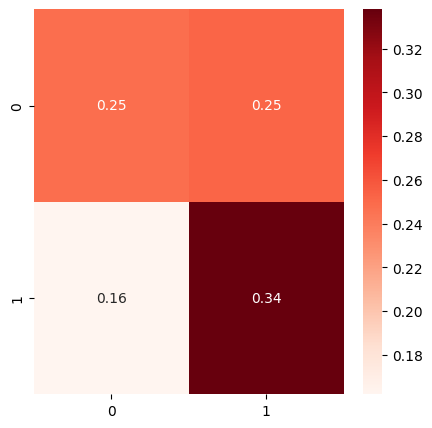

In [47]:
report(y_test, xgb_rfc_best.predict(x_test_selected))

## Бустинги

### Catboost

In [48]:
model = CatBoostClassifier(random_seed=42)

In [49]:
model.fit(
    x_train_selected,
    y_train,
    eval_set=(x_test_selected, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.03954
0:	learn: 0.6629678	test: 0.6916954	best: 0.6916954 (0)	total: 2.02ms	remaining: 2.02s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6522184244
bestIteration = 54

Shrink model to first 55 iterations.


In [50]:
f1_score(y_test, model.predict(x_test_selected))

0.639821029082774

In [51]:
model.get_feature_importance(catboost.Pool(x_train_selected))

array([ 9.35245549,  7.19719577,  6.17403398,  4.7607483 ,  7.50697687,
        5.95638927,  3.12231994,  8.74808234, 47.18179803])

In [52]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [53]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-11 10:39:31,736] A new study created in memory with name: no-name-7e367358-6461-4f09-96aa-84b85ac0f51d
[I 2024-11-11 10:39:32,667] Trial 0 finished with value: 0.6394557823129251 and parameters: {'learning_rate': 0.0062677026252401825, 'depth': 3, 'subsample': 0.9670501899863063, 'colsample_bylevel': 0.4348073304200823, 'min_data_in_leaf': 61, 'random_strength': 0.6842373434848628}. Best is trial 0 with value: 0.6394557823129251.
[I 2024-11-11 10:39:33,393] Trial 1 finished with value: 0.6111111111111112 and parameters: {'learning_rate': 0.06481769616120461, 'depth': 5, 'subsample': 0.5346408925257781, 'colsample_bylevel': 0.09074969071142808, 'min_data_in_leaf': 33, 'random_strength': 1.6302715544603585}. Best is trial 0 with value: 0.6394557823129251.
[I 2024-11-11 10:39:39,930] Trial 2 finished with value: 0.5949656750572083 and parameters: {'learning_rate': 0.06540089890755874, 'depth': 10, 'subsample': 0.18925425591224276, 'colsample_bylevel': 0.7295304939905973, 'min_d

In [54]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.008190558690886633, 'depth': 4, 'subsample': 0.4742242334318586, 'colsample_bylevel': 0.38893486743950234, 'min_data_in_leaf': 61, 'random_strength': 1.1336764140396607}
Best f1 score: 0.6503340757238308


In [55]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train_selected, y_train)

0:	learn: 0.6876730	total: 1.1ms	remaining: 1.1s
1:	learn: 0.6814492	total: 2.23ms	remaining: 1.11s
2:	learn: 0.6760735	total: 3.22ms	remaining: 1.07s
3:	learn: 0.6708659	total: 4.2ms	remaining: 1.04s
4:	learn: 0.6660035	total: 5.2ms	remaining: 1.03s
5:	learn: 0.6604142	total: 6.19ms	remaining: 1.02s
6:	learn: 0.6582632	total: 7.12ms	remaining: 1.01s
7:	learn: 0.6533266	total: 8.14ms	remaining: 1.01s
8:	learn: 0.6487627	total: 9.05ms	remaining: 996ms
9:	learn: 0.6472333	total: 9.97ms	remaining: 988ms
10:	learn: 0.6449347	total: 10.9ms	remaining: 980ms
11:	learn: 0.6400835	total: 11.9ms	remaining: 979ms
12:	learn: 0.6353599	total: 12.8ms	remaining: 972ms
13:	learn: 0.6331308	total: 13.7ms	remaining: 965ms
14:	learn: 0.6291111	total: 14.6ms	remaining: 960ms
15:	learn: 0.6250260	total: 15.6ms	remaining: 959ms
16:	learn: 0.6212361	total: 16.6ms	remaining: 958ms
17:	learn: 0.6168950	total: 17.5ms	remaining: 956ms
18:	learn: 0.6130035	total: 18.5ms	remaining: 954ms
19:	learn: 0.6092495	total

In [56]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6885490	total: 999us	remaining: 999ms
1:	learn: 0.6824984	total: 2.13ms	remaining: 1.06s
2:	learn: 0.6770197	total: 3ms	remaining: 996ms
3:	learn: 0.6719415	total: 3.85ms	remaining: 959ms
4:	learn: 0.6664257	total: 4.77ms	remaining: 949ms
5:	learn: 0.6614020	total: 5.64ms	remaining: 934ms
6:	learn: 0.6565617	total: 6.54ms	remaining: 928ms
7:	learn: 0.6518839	total: 7.42ms	remaining: 920ms
8:	learn: 0.6474046	total: 8.28ms	remaining: 912ms
9:	learn: 0.6425525	total: 9.18ms	remaining: 909ms
10:	learn: 0.6374672	total: 10.1ms	remaining: 907ms
11:	learn: 0.6329790	total: 11ms	remaining: 907ms
12:	learn: 0.6287275	total: 11.8ms	remaining: 898ms
13:	learn: 0.6266084	total: 12.6ms	remaining: 889ms
14:	learn: 0.6230788	total: 13.5ms	remaining: 885ms
15:	learn: 0.6194413	total: 14.4ms	remaining: 884ms
16:	learn: 0.6155668	total: 15.2ms	remaining: 879ms
17:	learn: 0.6115057	total: 16ms	remaining: 875ms
18:	learn: 0.6085777	total: 16.6ms	remaining: 857ms
19:	learn: 0.6055719	total: 17

{'fit_time': array([0.931422  , 0.94420695, 0.96824026, 0.98216748, 0.97339225]),
 'score_time': array([0.00811434, 0.00762177, 0.00825524, 0.01279879, 0.00778794]),
 'test_accuracy': array([0.8122449 , 0.85918367, 0.82244898, 0.80816327, 0.73265306]),
 'test_precision_macro': array([0.85287814, 0.84354749, 0.79687266, 0.78418079, 0.73337332]),
 'test_recall_macro': array([0.72213038, 0.83040719, 0.80158278, 0.81061772, 0.76616504]),
 'test_f1_macro': array([0.74617117, 0.83635915, 0.79911503, 0.79215177, 0.72435856]),
 'test_roc_auc': array([0.94959053, 0.91861901, 0.88821752, 0.87413783, 0.84219727])}

In [57]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.63      0.60      0.61       216
           1       0.62      0.65      0.63       216

    accuracy                           0.62       432
   macro avg       0.62      0.62      0.62       432
weighted avg       0.62      0.62      0.62       432

F2-score:  0.6416131989000916


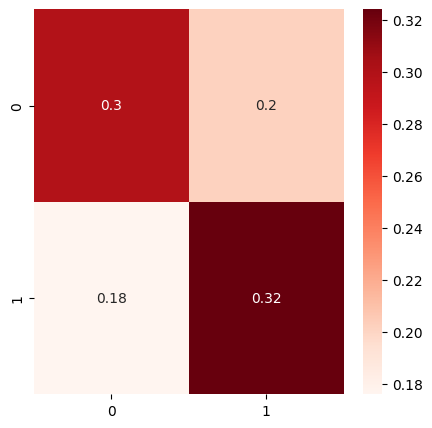

In [58]:
report(y_test, cb_best.predict(x_test_selected))

### XGBoost

In [59]:
model = XGBClassifier()

In [60]:
model.fit(
    x_train_selected,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [61]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [62]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-11 10:40:15,136] A new study created in memory with name: no-name-15c3a3f8-663a-465e-b03a-f3cee5f584fc


[10:40:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:15,950] Trial 0 finished with value: 0.5740740740740741 and parameters: {'learning_rate': 0.07440094193212601, 'max_depth': 158, 'n_estimators': 300, 'subsample': 0.5236935979177417, 'colsample_bylevel': 0.2704268313267208, 'gamma': 2.415151015669859}. Best is trial 0 with value: 0.5740740740740741.


[10:40:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:17,860] Trial 1 finished with value: 0.6023529411764705 and parameters: {'learning_rate': 0.0010801050252300449, 'max_depth': 174, 'n_estimators': 500, 'subsample': 0.9360848705254452, 'colsample_bylevel': 0.3756029778230898, 'gamma': 2.786427446260307}. Best is trial 1 with value: 0.6023529411764705.


[10:40:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:18,944] Trial 2 finished with value: 0.6308724832214765 and parameters: {'learning_rate': 0.0019984679300068214, 'max_depth': 207, 'n_estimators': 700, 'subsample': 0.1835921649372348, 'colsample_bylevel': 0.49039436956777965, 'gamma': 0.5287886921071707}. Best is trial 2 with value: 0.6308724832214765.


[10:40:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:21,370] Trial 3 finished with value: 0.5727699530516432 and parameters: {'learning_rate': 0.06497284843259273, 'max_depth': 331, 'n_estimators': 800, 'subsample': 0.6600423986447007, 'colsample_bylevel': 0.2665188331487967, 'gamma': 2.4104069000897215}. Best is trial 2 with value: 0.6308724832214765.


[10:40:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:22,695] Trial 4 finished with value: 0.596244131455399 and parameters: {'learning_rate': 0.0054845197118299945, 'max_depth': 454, 'n_estimators': 500, 'subsample': 0.5191858599550075, 'colsample_bylevel': 0.2958914483622021, 'gamma': 1.5130425117493596}. Best is trial 2 with value: 0.6308724832214765.


[10:40:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:24,744] Trial 5 finished with value: 0.5833333333333334 and parameters: {'learning_rate': 0.0403131227326797, 'max_depth': 155, 'n_estimators': 700, 'subsample': 0.9001429759010047, 'colsample_bylevel': 0.11912592504832825, 'gamma': 1.2696420254548468}. Best is trial 2 with value: 0.6308724832214765.


[10:40:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:25,203] Trial 6 finished with value: 0.594847775175644 and parameters: {'learning_rate': 0.012469595873247733, 'max_depth': 454, 'n_estimators': 500, 'subsample': 0.07429106938762926, 'colsample_bylevel': 0.8762412487239706, 'gamma': 0.6190576073810757}. Best is trial 2 with value: 0.6308724832214765.


[10:40:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:25,601] Trial 7 finished with value: 0.6027397260273972 and parameters: {'learning_rate': 0.03329540360853249, 'max_depth': 261, 'n_estimators': 200, 'subsample': 0.26985760820386867, 'colsample_bylevel': 0.9400803992952157, 'gamma': 1.1813249104870718}. Best is trial 2 with value: 0.6308724832214765.


[10:40:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:27,781] Trial 8 finished with value: 0.6287015945330295 and parameters: {'learning_rate': 0.0016780510333729661, 'max_depth': 129, 'n_estimators': 1000, 'subsample': 0.33223039861636755, 'colsample_bylevel': 0.6847658324922123, 'gamma': 1.9704579353874825}. Best is trial 2 with value: 0.6308724832214765.


[10:40:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:28,395] Trial 9 finished with value: 0.5740740740740741 and parameters: {'learning_rate': 0.06844974526785455, 'max_depth': 407, 'n_estimators': 500, 'subsample': 0.15516849059159443, 'colsample_bylevel': 0.9865790906569192, 'gamma': 0.7511809792622912}. Best is trial 2 with value: 0.6308724832214765.


[10:40:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:30,659] Trial 10 finished with value: 0.6100917431192661 and parameters: {'learning_rate': 0.0027790615201442365, 'max_depth': 260, 'n_estimators': 1000, 'subsample': 0.34781809486723914, 'colsample_bylevel': 0.585147975247462, 'gamma': 0.12636796711510678}. Best is trial 2 with value: 0.6308724832214765.


[10:40:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:32,837] Trial 11 finished with value: 0.6227272727272727 and parameters: {'learning_rate': 0.0010075006006858137, 'max_depth': 118, 'n_estimators': 1000, 'subsample': 0.34943907514105427, 'colsample_bylevel': 0.6459943533025287, 'gamma': 1.8555448807219783}. Best is trial 2 with value: 0.6308724832214765.


[10:40:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:34,234] Trial 12 finished with value: 0.6244343891402715 and parameters: {'learning_rate': 0.0026913224662139384, 'max_depth': 227, 'n_estimators': 800, 'subsample': 0.22904871589689857, 'colsample_bylevel': 0.7447407884959962, 'gamma': 1.9517305496816488}. Best is trial 2 with value: 0.6308724832214765.


[10:40:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:36,247] Trial 13 finished with value: 0.6082949308755761 and parameters: {'learning_rate': 0.002379417158996777, 'max_depth': 101, 'n_estimators': 800, 'subsample': 0.4176292875984443, 'colsample_bylevel': 0.471435219632232, 'gamma': 0.3075002627433009}. Best is trial 2 with value: 0.6308724832214765.


[10:40:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:40,236] Trial 14 finished with value: 0.5821596244131455 and parameters: {'learning_rate': 0.00776306606489259, 'max_depth': 203, 'n_estimators': 1000, 'subsample': 0.7006240502371646, 'colsample_bylevel': 0.7454898442938763, 'gamma': 2.022445236775091}. Best is trial 2 with value: 0.6308724832214765.


[10:40:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:40,993] Trial 15 finished with value: 0.6378132118451025 and parameters: {'learning_rate': 0.0016797949532783942, 'max_depth': 325, 'n_estimators': 700, 'subsample': 0.10673707585965714, 'colsample_bylevel': 0.46363055835480954, 'gamma': 0.9621527787867087}. Best is trial 15 with value: 0.6378132118451025.


[10:40:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:41,663] Trial 16 finished with value: 0.6139534883720931 and parameters: {'learning_rate': 0.00438506621768352, 'max_depth': 341, 'n_estimators': 700, 'subsample': 0.07836966784460354, 'colsample_bylevel': 0.4700099529989513, 'gamma': 0.7949402316395728}. Best is trial 15 with value: 0.6378132118451025.


[10:40:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:42,474] Trial 17 finished with value: 0.5774647887323944 and parameters: {'learning_rate': 0.009885494622617362, 'max_depth': 375, 'n_estimators': 700, 'subsample': 0.17583509769052616, 'colsample_bylevel': 0.09476654812976715, 'gamma': 1.020533212237186}. Best is trial 15 with value: 0.6378132118451025.


[10:40:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:42,728] Trial 18 finished with value: 0.5985748218527317 and parameters: {'learning_rate': 0.016262930244549296, 'max_depth': 297, 'n_estimators': 300, 'subsample': 0.05400789895693889, 'colsample_bylevel': 0.3946047974765115, 'gamma': 0.4346586326543176}. Best is trial 15 with value: 0.6378132118451025.


[10:40:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:44,197] Trial 19 finished with value: 0.6036866359447005 and parameters: {'learning_rate': 0.0017008438046934133, 'max_depth': 292, 'n_estimators': 600, 'subsample': 0.43181973500112, 'colsample_bylevel': 0.5172504308044814, 'gamma': 0.9557402551298197}. Best is trial 15 with value: 0.6378132118451025.


[10:40:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:45,289] Trial 20 finished with value: 0.5893719806763285 and parameters: {'learning_rate': 0.00486005232069457, 'max_depth': 222, 'n_estimators': 900, 'subsample': 0.18451973612978143, 'colsample_bylevel': 0.18673285177376292, 'gamma': 1.4849329480260491}. Best is trial 15 with value: 0.6378132118451025.


[10:40:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:47,030] Trial 21 finished with value: 0.6153846153846153 and parameters: {'learning_rate': 0.0015894250109979144, 'max_depth': 138, 'n_estimators': 900, 'subsample': 0.2895934914956795, 'colsample_bylevel': 0.640914778109206, 'gamma': 1.7492364488639751}. Best is trial 15 with value: 0.6378132118451025.


[10:40:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:47,769] Trial 22 finished with value: 0.64 and parameters: {'learning_rate': 0.0017649606721458358, 'max_depth': 195, 'n_estimators': 600, 'subsample': 0.1410696325150933, 'colsample_bylevel': 0.6923647240878904, 'gamma': 0.5037110282005772}. Best is trial 22 with value: 0.64.


[10:40:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:48,549] Trial 23 finished with value: 0.6410835214446953 and parameters: {'learning_rate': 0.003443103888319129, 'max_depth': 192, 'n_estimators': 600, 'subsample': 0.13965310659788494, 'colsample_bylevel': 0.8168545359202047, 'gamma': 0.42160763769843734}. Best is trial 23 with value: 0.6410835214446953.


[10:40:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:49,317] Trial 24 finished with value: 0.6303854875283447 and parameters: {'learning_rate': 0.0033545774750197797, 'max_depth': 259, 'n_estimators': 600, 'subsample': 0.13436100101142354, 'colsample_bylevel': 0.8521466774500901, 'gamma': 0.21832958812634834}. Best is trial 23 with value: 0.6410835214446953.


[10:40:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:50,737] Trial 25 finished with value: 0.6049661399548533 and parameters: {'learning_rate': 0.0012590184275913896, 'max_depth': 330, 'n_estimators': 400, 'subsample': 0.6823329084919381, 'colsample_bylevel': 0.795654776012312, 'gamma': 0.73368248494031}. Best is trial 23 with value: 0.6410835214446953.


[10:40:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:51,862] Trial 26 finished with value: 0.6073059360730593 and parameters: {'learning_rate': 0.0036584406467224453, 'max_depth': 185, 'n_estimators': 600, 'subsample': 0.24398135863714898, 'colsample_bylevel': 0.843471790333246, 'gamma': 0.4175390983708538}. Best is trial 23 with value: 0.6410835214446953.


[10:40:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:53,480] Trial 27 finished with value: 0.5833333333333334 and parameters: {'learning_rate': 0.00693801131080864, 'max_depth': 377, 'n_estimators': 400, 'subsample': 0.7704769021474733, 'colsample_bylevel': 0.598461715741019, 'gamma': 0.9716529561514684}. Best is trial 23 with value: 0.6410835214446953.


[10:40:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:53,614] Trial 28 finished with value: 0.6376146788990824 and parameters: {'learning_rate': 0.0013948105238526767, 'max_depth': 243, 'n_estimators': 100, 'subsample': 0.11138980026736173, 'colsample_bylevel': 0.7375149185731023, 'gamma': 1.1257371137314163}. Best is trial 23 with value: 0.6410835214446953.


[10:40:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:40:55,184] Trial 29 finished with value: 0.6073059360730593 and parameters: {'learning_rate': 0.002280912907939883, 'max_depth': 288, 'n_estimators': 600, 'subsample': 0.4436424218025144, 'colsample_bylevel': 0.5501534558231771, 'gamma': 1.3362192799903547}. Best is trial 23 with value: 0.6410835214446953.


In [63]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.003443103888319129, 'max_depth': 192, 'n_estimators': 600, 'subsample': 0.13965310659788494, 'colsample_bylevel': 0.8168545359202047, 'gamma': 0.42160763769843734}
Best f1 score: 0.6410835214446953


In [64]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train_selected, y_train)

[10:40:55] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8168545359202047, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.42160763769843734, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.003443103888319129, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=192, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [65]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

[10:40:55] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:40:56] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:40:57] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:40:57] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:40:58] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([0.60520649, 0.61618924, 0.61232567, 0.61684418, 0.71643925]),
 'score_time': array([0.01493502, 0.01501489, 0.01424623, 0.01457572, 0.01422596]),
 'test_accuracy': array([0.81632653, 0.85102041, 0.83061224, 0.80204082, 0.73673469]),
 'test_precision_macro': array([0.8649481 , 0.83303922, 0.80581586, 0.77657895, 0.73745502]),
 'test_recall_macro': array([0.72515153, 0.82273081, 0.81252731, 0.79954968, 0.77082027]),
 'test_f1_macro': array([0.75027747, 0.8274806 , 0.80894891, 0.7841694 , 0.72856683]),
 'test_roc_auc': array([0.93450379, 0.90746547, 0.88749549, 0.87007163, 0.82779456])}

In [66]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.64      0.61      0.62       216
           1       0.63      0.66      0.64       216

    accuracy                           0.63       432
   macro avg       0.63      0.63      0.63       432
weighted avg       0.63      0.63      0.63       432

F2-score:  0.6507791017415215


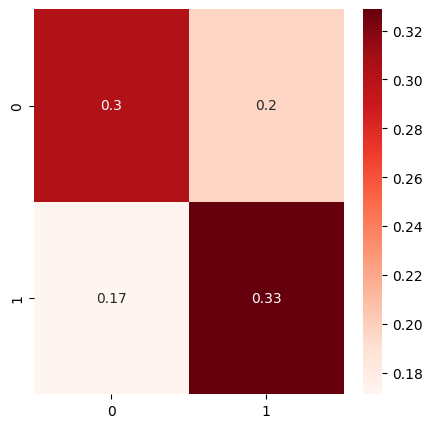

In [67]:
report(y_test, xgb_best.predict(x_test_selected))

### LightGBM

In [68]:
model = LGBMClassifier()

In [69]:
model.fit(
    x_train_selected,
    y_train,
    )

LGBMClassifier()

In [70]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [71]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-11 10:40:59,632] A new study created in memory with name: no-name-b17631c6-a55a-42b9-8a02-cc618dc955a8


[10:40:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:01,205] Trial 0 finished with value: 0.6078886310904872 and parameters: {'learning_rate': 0.0011250051478811376, 'max_depth': 492, 'n_estimators': 600, 'subsample': 0.4882491765657216, 'colsample_bylevel': 0.41227048953536366, 'gamma': 0.7250769378893296}. Best is trial 0 with value: 0.6078886310904872.


[10:41:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:04,198] Trial 1 finished with value: 0.5879629629629629 and parameters: {'learning_rate': 0.046992569733406535, 'max_depth': 458, 'n_estimators': 900, 'subsample': 0.9132993734724976, 'colsample_bylevel': 0.28415920896108, 'gamma': 0.6813652891194993}. Best is trial 0 with value: 0.6078886310904872.


[10:41:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:04,486] Trial 2 finished with value: 0.44036697247706424 and parameters: {'learning_rate': 0.0028488102897721405, 'max_depth': 171, 'n_estimators': 400, 'subsample': 0.062447255472946515, 'colsample_bylevel': 0.18596253467594875, 'gamma': 0.31277767865934897}. Best is trial 0 with value: 0.6078886310904872.


[10:41:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:05,425] Trial 3 finished with value: 0.5986078886310905 and parameters: {'learning_rate': 0.07013318356396711, 'max_depth': 219, 'n_estimators': 400, 'subsample': 0.47111592678002273, 'colsample_bylevel': 0.4843027822981181, 'gamma': 0.39559878839306395}. Best is trial 0 with value: 0.6078886310904872.


[10:41:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:05,640] Trial 4 finished with value: 0.5681293302540414 and parameters: {'learning_rate': 0.05943217075564544, 'max_depth': 203, 'n_estimators': 200, 'subsample': 0.10427809437382234, 'colsample_bylevel': 0.6131513438041032, 'gamma': 2.497357162923444}. Best is trial 0 with value: 0.6078886310904872.


[10:41:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:06,200] Trial 5 finished with value: 0.5913461538461537 and parameters: {'learning_rate': 0.007457552058038636, 'max_depth': 251, 'n_estimators': 300, 'subsample': 0.4504254497347869, 'colsample_bylevel': 0.2026905867122784, 'gamma': 2.0680494344453817}. Best is trial 0 with value: 0.6078886310904872.


[10:41:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:06,336] Trial 6 finished with value: 0.6160919540229884 and parameters: {'learning_rate': 0.04776599839486533, 'max_depth': 327, 'n_estimators': 200, 'subsample': 0.05241714636519987, 'colsample_bylevel': 0.1599387544439983, 'gamma': 2.970131896745548}. Best is trial 6 with value: 0.6160919540229884.


[10:41:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:06,918] Trial 7 finished with value: 0.585480093676815 and parameters: {'learning_rate': 0.044082657964696084, 'max_depth': 499, 'n_estimators': 400, 'subsample': 0.20049883494424642, 'colsample_bylevel': 0.40719459382227435, 'gamma': 1.0656743985381438}. Best is trial 6 with value: 0.6160919540229884.


[10:41:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:07,844] Trial 8 finished with value: 0.5890410958904109 and parameters: {'learning_rate': 0.04402882155416305, 'max_depth': 187, 'n_estimators': 1000, 'subsample': 0.09381169316514668, 'colsample_bylevel': 0.4974362643012981, 'gamma': 1.978640079152282}. Best is trial 6 with value: 0.6160919540229884.
[I 2024-11-11 10:41:08,002] Trial 9 finished with value: 0.6244343891402715 and parameters: {'learning_rate': 0.002081007696174202, 'max_depth': 325, 'n_estimators': 100, 'subsample': 0.2119863582236785, 'colsample_bylevel': 0.761234397391269, 'gamma': 2.1263789467428853}. Best is trial 9 with value: 0.6244343891402715.


[10:41:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[10:41:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:08,397] Trial 10 finished with value: 0.576036866359447 and parameters: {'learning_rate': 0.001018811764957624, 'max_depth': 332, 'n_estimators': 100, 'subsample': 0.7848717154935608, 'colsample_bylevel': 0.9205370557507202, 'gamma': 1.613244658631706}. Best is trial 9 with value: 0.6244343891402715.


[10:41:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:08,637] Trial 11 finished with value: 0.6241457858769932 and parameters: {'learning_rate': 0.01311516641934071, 'max_depth': 345, 'n_estimators': 100, 'subsample': 0.3054912254396689, 'colsample_bylevel': 0.7254675166646092, 'gamma': 2.741062610405762}. Best is trial 9 with value: 0.6244343891402715.


[10:41:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:10,142] Trial 12 finished with value: 0.5833333333333334 and parameters: {'learning_rate': 0.013877090050026025, 'max_depth': 389, 'n_estimators': 700, 'subsample': 0.3088639709427883, 'colsample_bylevel': 0.7708756232037911, 'gamma': 2.886296855316227}. Best is trial 9 with value: 0.6244343891402715.


[10:41:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:10,368] Trial 13 finished with value: 0.6327433628318585 and parameters: {'learning_rate': 0.012037271055661918, 'max_depth': 113, 'n_estimators': 100, 'subsample': 0.2913425825361938, 'colsample_bylevel': 0.737320034116952, 'gamma': 2.3867379758928866}. Best is trial 13 with value: 0.6327433628318585.


[10:41:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:10,830] Trial 14 finished with value: 0.625 and parameters: {'learning_rate': 0.005277426437054387, 'max_depth': 104, 'n_estimators': 200, 'subsample': 0.30514120766988695, 'colsample_bylevel': 0.9936020672798788, 'gamma': 2.2778045535920253}. Best is trial 13 with value: 0.6327433628318585.


[10:41:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:11,562] Trial 15 finished with value: 0.6157407407407407 and parameters: {'learning_rate': 0.006547364927341286, 'max_depth': 106, 'n_estimators': 300, 'subsample': 0.35685779423749586, 'colsample_bylevel': 0.9914836824578355, 'gamma': 2.422952177892981}. Best is trial 13 with value: 0.6327433628318585.


[10:41:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:14,175] Trial 16 finished with value: 0.5767441860465116 and parameters: {'learning_rate': 0.019203747388713787, 'max_depth': 100, 'n_estimators': 600, 'subsample': 0.7996713266910171, 'colsample_bylevel': 0.8734573636731047, 'gamma': 1.4572183849445854}. Best is trial 13 with value: 0.6327433628318585.


[10:41:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:17,171] Trial 17 finished with value: 0.6013986013986014 and parameters: {'learning_rate': 0.003727236923897249, 'max_depth': 154, 'n_estimators': 800, 'subsample': 0.6201605514001606, 'colsample_bylevel': 0.6521733846725981, 'gamma': 1.6954228621387277}. Best is trial 13 with value: 0.6327433628318585.


[10:41:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:17,902] Trial 18 finished with value: 0.6161137440758294 and parameters: {'learning_rate': 0.02230067086924478, 'max_depth': 269, 'n_estimators': 200, 'subsample': 0.58781888422449, 'colsample_bylevel': 0.8606767240831715, 'gamma': 2.4315927033933837}. Best is trial 13 with value: 0.6327433628318585.


[10:41:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:18,754] Trial 19 finished with value: 0.6143497757847532 and parameters: {'learning_rate': 0.004999834991760633, 'max_depth': 140, 'n_estimators': 500, 'subsample': 0.21445910650592193, 'colsample_bylevel': 0.9934446153217998, 'gamma': 1.8596698040549215}. Best is trial 13 with value: 0.6327433628318585.


[10:41:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:19,501] Trial 20 finished with value: 0.6031746031746031 and parameters: {'learning_rate': 0.009550116147359882, 'max_depth': 132, 'n_estimators': 300, 'subsample': 0.3787121111572787, 'colsample_bylevel': 0.6341827184021347, 'gamma': 1.354229938449044}. Best is trial 13 with value: 0.6327433628318585.


[10:41:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:19,682] Trial 21 finished with value: 0.6258503401360543 and parameters: {'learning_rate': 0.002519325267575148, 'max_depth': 379, 'n_estimators': 100, 'subsample': 0.21996073650754216, 'colsample_bylevel': 0.7742819331510405, 'gamma': 2.19842225198213}. Best is trial 13 with value: 0.6327433628318585.


[10:41:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:19,919] Trial 22 finished with value: 0.5055555555555555 and parameters: {'learning_rate': 0.0017757648208270953, 'max_depth': 398, 'n_estimators': 100, 'subsample': 0.23284682235884285, 'colsample_bylevel': 0.052764512089136906, 'gamma': 2.2410049630867688}. Best is trial 13 with value: 0.6327433628318585.


[10:41:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:20,206] Trial 23 finished with value: 0.6492374727668846 and parameters: {'learning_rate': 0.0040417330650392245, 'max_depth': 377, 'n_estimators': 200, 'subsample': 0.15635521372500855, 'colsample_bylevel': 0.8350948925966797, 'gamma': 2.6187718149336487}. Best is trial 23 with value: 0.6492374727668846.


[10:41:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:20,370] Trial 24 finished with value: 0.6349206349206349 and parameters: {'learning_rate': 0.003246044106122789, 'max_depth': 396, 'n_estimators': 100, 'subsample': 0.1676991477898463, 'colsample_bylevel': 0.8218197842530383, 'gamma': 2.6186682935490344}. Best is trial 23 with value: 0.6492374727668846.


[10:41:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:20,783] Trial 25 finished with value: 0.645879732739421 and parameters: {'learning_rate': 0.003785929783431155, 'max_depth': 426, 'n_estimators': 300, 'subsample': 0.15084933000770928, 'colsample_bylevel': 0.8413863338514751, 'gamma': 2.643284119324337}. Best is trial 23 with value: 0.6492374727668846.


[10:41:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:21,188] Trial 26 finished with value: 0.6534216335540839 and parameters: {'learning_rate': 0.0035223793094371477, 'max_depth': 425, 'n_estimators': 300, 'subsample': 0.14470475172755864, 'colsample_bylevel': 0.8440678235896744, 'gamma': 2.6678039360024033}. Best is trial 26 with value: 0.6534216335540839.


[10:41:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:21,827] Trial 27 finished with value: 0.6442953020134228 and parameters: {'learning_rate': 0.0017636083849393303, 'max_depth': 439, 'n_estimators': 500, 'subsample': 0.14846454899450118, 'colsample_bylevel': 0.5779540533554097, 'gamma': 2.811971638462503}. Best is trial 26 with value: 0.6534216335540839.


[10:41:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:22,206] Trial 28 finished with value: 0.6428571428571429 and parameters: {'learning_rate': 0.004405891389290489, 'max_depth': 423, 'n_estimators': 300, 'subsample': 0.12800664258352307, 'colsample_bylevel': 0.9162776024505971, 'gamma': 2.6688342738613597}. Best is trial 26 with value: 0.6534216335540839.


[10:41:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:41:23,476] Trial 29 finished with value: 0.6206896551724138 and parameters: {'learning_rate': 0.0015604939756692666, 'max_depth': 464, 'n_estimators': 500, 'subsample': 0.42315390058853836, 'colsample_bylevel': 0.6710760768080717, 'gamma': 1.1728735343907815}. Best is trial 26 with value: 0.6534216335540839.


In [72]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.0035223793094371477, 'max_depth': 425, 'n_estimators': 300, 'subsample': 0.14470475172755864, 'colsample_bylevel': 0.8440678235896744, 'gamma': 2.6678039360024033}
Best f1 score: 0.6534216335540839


In [73]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train_selected, y_train)

LGBMClassifier(learning_rate=0.0035223793094371477, max_depth=425,
               n_estimators=300, random_seed=42, subsample=0.14470475172755864)

In [74]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.20932364, 0.22241068, 0.21224785, 0.20163321, 0.19381595]),
 'score_time': array([0.01071382, 0.01083136, 0.01159549, 0.01072884, 0.01151156]),
 'test_accuracy': array([0.76122449, 0.83469388, 0.8122449 , 0.79387755, 0.74489796]),
 'test_precision_macro': array([0.83159091, 0.82108419, 0.78814383, 0.7652868 , 0.72534614]),
 'test_recall_macro': array([0.63861179, 0.79103726, 0.77605503, 0.76082578, 0.75235137]),
 'test_f1_macro': array([0.64422021, 0.80282278, 0.78142394, 0.762946  , 0.72890913]),
 'test_roc_auc': array([0.93440879, 0.89233122, 0.87994262, 0.85814855, 0.8204887 ])}

In [75]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.54      0.73      0.62       216
           1       0.58      0.37      0.45       216

    accuracy                           0.55       432
   macro avg       0.56      0.55      0.54       432
weighted avg       0.56      0.55      0.54       432

F2-score:  0.39920159680638717


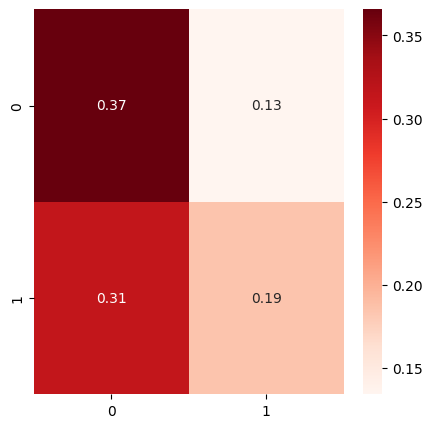

In [76]:
report(y_test, lgbm_best.predict(x_test_selected))

# Результаты

In [77]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [78]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [79]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [80]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.79 +- 0.03 , 'AUC': 0.88 +- 0.03 ,'Precision': 0.79 +- 0.03 ,'Recall': 0.74 +- 0.06 ,'F1-score': 0.73 +- 0.07 ,'F2-score': 0.74 +- 0.05
'Accuracy': 0.8 +- 0.05 , 'AUC': 0.89 +- 0.03 ,'Precision': 0.8 +- 0.05 ,'Recall': 0.79 +- 0.02 ,'F1-score': 0.78 +- 0.04 ,'F2-score': 0.79 +- 0.02
'Accuracy': 0.81 +- 0.04 , 'AUC': 0.89 +- 0.04 ,'Precision': 0.8 +- 0.04 ,'Recall': 0.79 +- 0.04 ,'F1-score': 0.78 +- 0.04 ,'F2-score': 0.79 +- 0.03
'Accuracy': 0.79 +- 0.03 , 'AUC': 0.88 +- 0.04 ,'Precision': 0.79 +- 0.04 ,'Recall': 0.74 +- 0.05 ,'F1-score': 0.74 +- 0.06 ,'F2-score': 0.75 +- 0.04
'Accuracy': 0.81 +- 0.04 , 'AUC': 0.89 +- 0.04 ,'Precision': 0.8 +- 0.04 ,'Recall': 0.79 +- 0.04 ,'F1-score': 0.78 +- 0.04 ,'F2-score': 0.79 +- 0.03


In [81]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test_selected, y_test))

{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.69, 'Recall': 0.32, 'F1-score': 0.44, 'F2-score': 0.36}
{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.57, 'Recall': 0.68, 'F1-score': 0.62, 'F2-score': 0.65}
{'Accuracy': 0.63, 'AUC': 0.63, 'Precision': 0.63, 'Recall': 0.66, 'F1-score': 0.64, 'F2-score': 0.65}
{'Accuracy': 0.55, 'AUC': 0.55, 'Precision': 0.58, 'Recall': 0.37, 'F1-score': 0.45, 'F2-score': 0.4}
{'Accuracy': 0.62, 'AUC': 0.62, 'Precision': 0.62, 'Recall': 0.65, 'F1-score': 0.63, 'F2-score': 0.64}


In [82]:
import shap
shap.initjs()

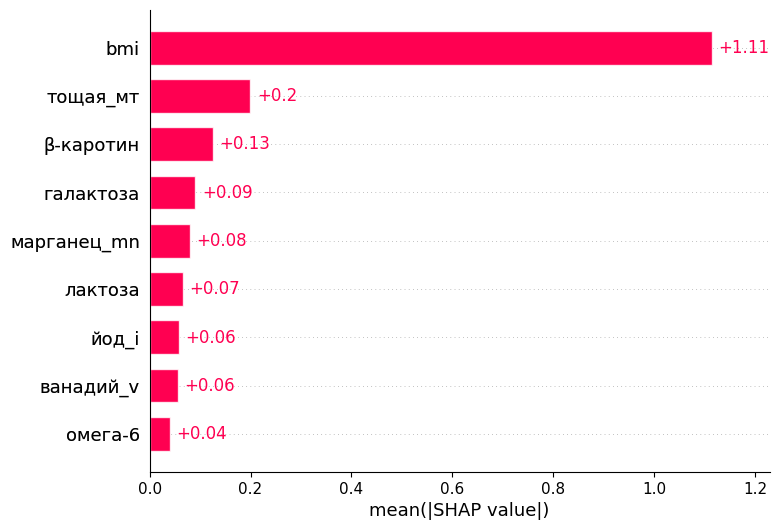

In [88]:
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer(x_train_selected)
shap.plots.bar(shap_values)